# Linear Regression Health Costs Calculator

In this project, the goal was to predict healthcare costs using a regression algorithm.

I also will use PyTorch for this notebook, but you can always see the original solution with TensorFlow below.

To see the original solution refer to [here]("https://colab.research.google.com/drive/1gO8bcKY4yxBfVVyEK3bBUjEeOZOXBnAZ?usp=sharing") and more informations [here]("https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/linear-regression-health-costs-calculator")

---

In [1]:
# Import libraries. You may or may not use all of these.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 

import torch
from torch import nn

c:\Users\Lucas\AppData\Local\Programs\Python\data-science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import requests
from pathlib import Path

# Import data
data_path = Path("data")
insurance_path = data_path / "insurance"

if insurance_path.is_dir():
    print(f"{insurance_path} already exists, skipping download!")
else:
    print(f"Creating {insurance_path}")
    insurance_path.mkdir(parents=True, exist_ok=True)

    with open(insurance_path / "insurance.csv", 'wb') as f:
        print("Downloading insurance data...")
        request = requests.get("https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv")
        f.write(request.content)

Creating data\insurance


In [3]:
dataset = pd.read_csv(insurance_path / 'insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [4]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['sex'],prefix="sex")], axis=1)
dataset.drop('sex', axis=1, inplace=True)

dataset = pd.concat([dataset, pd.get_dummies(dataset['smoker'], prefix="smoker")], axis=1)
dataset.drop('smoker', axis=1, inplace=True)

dataset = pd.concat([dataset, pd.get_dummies(dataset['region'], prefix="region")], axis=1)
dataset.drop('region', axis=1, inplace=True)
dataset

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,1,0,0,1,0,0,0,1
1,18,33.8,1,1725.55,0,1,1,0,0,0,1,0
2,28,33.0,3,4449.46,0,1,1,0,0,0,1,0
3,33,22.7,0,21984.47,0,1,1,0,0,1,0,0
4,32,28.9,0,3866.86,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,10600.55,0,1,1,0,0,1,0,0
1334,18,31.9,0,2205.98,1,0,1,0,1,0,0,0
1335,18,36.9,0,1629.83,1,0,1,0,0,0,1,0
1336,21,25.8,0,2007.95,1,0,1,0,0,0,0,1


In [14]:
x_columns = dataset.columns.drop('expenses')
x = dataset[x_columns].values
y = dataset['expenses'].values

x[0], y[0]

(array([19. , 27.9,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  1. ]),
 16884.92)

In [25]:
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)

X[0], Y[0]

(tensor([19.0000, 27.9000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  1.0000]),
 tensor(16884.9199))

In [26]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, Y, train_size=0.8)

len(train_dataset), len(test_dataset), len(train_labels), len(test_labels)

(1070, 268, 1070, 268)

In [132]:
class PredictHealthCostsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_block = nn.Sequential(
            nn.Linear(in_features=11, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=25),
            nn.ReLU(),
            nn.Linear(in_features=25, out_features=1)
        )
    def forward(self, x):
        return self.layer_block(x)

In [133]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available else "cpu"
device

'cuda'

In [134]:
model = PredictHealthCostsModel().to(device)
model

PredictHealthCostsModel(
  (layer_block): Sequential(
    (0): Linear(in_features=11, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [135]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

epochs = 501

train_dataset, train_labels = train_dataset.to(device), train_labels.to(device)
test_dataset, test_labels = test_dataset.to(device), test_labels.to(device)

for epoch in range(epochs):
    model.train()

    y_pred = model(train_dataset).squeeze()

    loss = loss_fn(y_pred, train_labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(test_dataset).squeeze()

        test_loss = loss_fn(test_pred, test_labels)
    

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 13193.5986328125 | Test loss: 13505.2763671875
Epoch: 50 | Train loss: 6325.20751953125 | Test loss: 6641.65087890625
Epoch: 100 | Train loss: 4095.528076171875 | Test loss: 4032.14501953125
Epoch: 150 | Train loss: 3160.834228515625 | Test loss: 2998.00732421875
Epoch: 200 | Train loss: 2814.4375 | Test loss: 2488.113037109375
Epoch: 250 | Train loss: 2998.77685546875 | Test loss: 2453.30029296875
Epoch: 300 | Train loss: 2312.8916015625 | Test loss: 2316.1240234375
Epoch: 350 | Train loss: 2348.82763671875 | Test loss: 2064.248291015625
Epoch: 400 | Train loss: 2117.24560546875 | Test loss: 2103.753173828125
Epoch: 450 | Train loss: 2106.556640625 | Test loss: 2302.879638671875
Epoch: 500 | Train loss: 1955.2528076171875 | Test loss: 2062.876953125


Testing set Mean Abs Error: 2062.88 expenses
You passed the challenge. Great job!


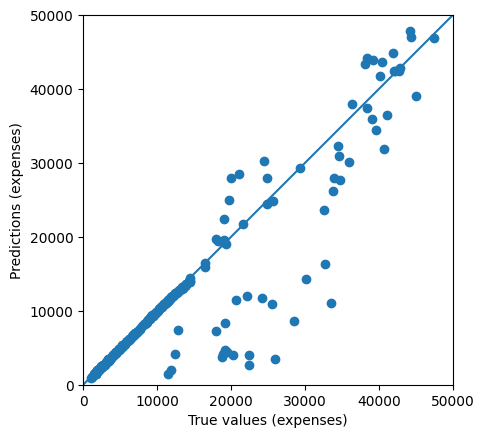

In [139]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
model.eval()
with torch.inference_mode():
    test_predictions = model(test_dataset).squeeze()

    mae = loss_fn(test_pred, test_labels)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
a = plt.axes(aspect='equal')
plt.scatter(test_labels.cpu(), test_predictions.cpu())
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

**SUCCESS!!**

The Mean Absolute Error was well below the 3.5K mark so we got it!

This code changed very little compared to the TF one because it was a simpler model, CNN are way more complex than linear regression ones.